In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc
from prj.config import DATA_DIR
from tqdm import tqdm

In [3]:
from prj.agents.factory import AgentsFactory
from prj.config import EXP_DIR
import os

agent_base_dir = EXP_DIR / 'train'

agents_dict = [
    {'agent_type': 'lgbm', 'load_path': os.path.join(agent_base_dir, "lgbm_6-6_20241119_203611", "models")},
    {'agent_type': 'lgbm', 'load_path': os.path.join(agent_base_dir, "lgbm_7-7_20241119_204200", "models")},
    {'agent_type': 'lgbm', 'load_path': os.path.join(agent_base_dir, "lgbm_8-8_20241119_204744", "models")},
    # {'agent_type': 'xgb', 'load_path': os.path.join(agent_base_dir, "xgb_5-5_20241119_222538", "models")},

]

agents = [AgentsFactory.load_agent(agent_dict) for agent_dict in agents_dict]

len(agents)

Loading models, overwriting seeds: [3637629852, 4077466057, 4264274211]
Loading models, overwriting seeds: [842516502, 1077737561, 1458143422]
Loading models, overwriting seeds: [1291678822, 2434657110, 3703472945]


3

In [4]:
from prj.scripts.train_tree_regressor import RegressorTrainer
partitions = [9]
# X_test, y_test, w_test, info = RegressorTrainer.prepare_dataset(partitions)
# np.savez(DATA_DIR / f"x_{'_'.join([str(part) for part in partitions])}.npz", X_test=X_test, y_test=y_test, w_test=w_test, info=info)

X_test, y_test, w_test, info = np.load(DATA_DIR / f"x_{'_'.join([str(part) for part in partitions])}.npz", allow_pickle=True).values()

t = 1000000
X_test = X_test[:t]
y_test = y_test[:t]
w_test = w_test[:t]
info = info[:t]

X_test.shape, y_test.shape, w_test.shape, info.shape

((1000000, 79), (1000000,), (1000000,), (1000000, 3))

In [5]:
def squared_weighted_error_loss_fn(y_true: np.ndarray, y_pred_agents: np.ndarray, w: np.ndarray) -> np.ndarray:
    return w.reshape(-1, 1) * ((y_true.reshape(-1, 1) - y_pred_agents) ** 2)

def absolute_weighted_error_loss_fn(y_true: np.ndarray, y_pred_agents: np.ndarray, w: np.ndarray) -> np.ndarray:
    return w.reshape(-1, 1) * np.abs(y_true.reshape(-1, 1) - y_pred_agents)

def compute_loss(y_true: np.ndarray, y_pred_agents: np.ndarray, w: np.ndarray, loss_fn) -> np.ndarray:
    assert y_true.shape[0] == y_pred_agents.shape[0]
    if w is None:
        w = np.ones_like(y_true)
    assert y_true.shape[0] == w.shape[0]

    return loss_fn(y_true, y_pred_agents, w)


agents_predictions = np.concatenate([agent.predict(X_test).reshape(-1, 1) for agent in tqdm(agents)], axis=1)
agents_losses = compute_loss(y_test, agents_predictions, w_test, absolute_weighted_error_loss_fn)
agents_predictions.shape, agents_losses.shape

100%|██████████| 3/3 [00:07<00:00,  2.35s/it]


((1000000, 3), (1000000, 3))

In [24]:
from prj.metrics import weighted_r2
from prj.oamp.oamp import OAMP
from prj.oamp.oamp_config import ConfigOAMP

_, days = np.unique(info[:, 0], return_counts=True)

oamp_args = ConfigOAMP({'agents_weights_upd_freq': 1, 'loss_fn_window': 1000})
n_agents = len(agents)
oamp: OAMP = OAMP(n_agents, oamp_args, groups=days)

ensemble_preds = []
for i in tqdm(range(agents_predictions.shape[0])):    
    ensemble_prediction = oamp.step(agents_losses[i], agents_predictions[i])
    ensemble_preds.append(ensemble_prediction)


ensemble_preds = np.array(ensemble_preds)

ensemble_preds.shape

100%|██████████| 1000000/1000000 [00:04<00:00, 247128.55it/s]


(1000000,)

In [25]:
from prj.metrics import weighted_mae, weighted_mse, weighted_rmse

def metrics(y_true, y_pred, weights):
    return {
        'r2_w': weighted_r2(y_true, y_pred, weights=weights),
        'mae_w': weighted_mae(y_true, y_pred, weights=weights),
        'mse_w': weighted_mse(y_true, y_pred, weights=weights),
        'rmse_w': weighted_rmse(y_true, y_pred, weights=weights),
    }
    
results = {}
res = metrics(y_test, ensemble_preds, w_test)
columns = list(res.keys())
results['ensemble'] = res.values()
for i in range(n_agents):
    results[f'agent_{i}'] = metrics(y_test, agents_predictions[:, i], w_test).values()
results['mean'] = metrics(y_test, np.mean(agents_predictions, axis=1), w_test).values()
results['median'] = metrics(y_test, np.median(agents_predictions, axis=1), w_test).values()


results = pl.DataFrame(results)\
    .transpose(include_header=True, column_names=columns, header_name='Agent')\
    .sort('r2_w', descending=True) \
    .to_pandas().set_index('Agent')
results

,r2_w,mae_w,mse_w,rmse_w
Agent,,,,
ensemble,0.010056,0.488295,0.551133,0.742383
mean,0.009373,0.488460,0.551513,0.742639
median,0.009035,0.488434,0.551701,0.742766
agent_1,0.008842,0.488621,0.551808,0.742838
agent_2,0.008600,0.488949,0.551943,0.742929
agent_0,0.001790,0.489956,0.555734,0.745476


In [26]:
(np.sum(agents_losses, axis=0) - np.sum(agents_losses, axis=0).min()) / (np.sum(agents_losses, axis=0).max() - np.sum(agents_losses, axis=0).min())

array([1.        , 0.        , 0.24580794])

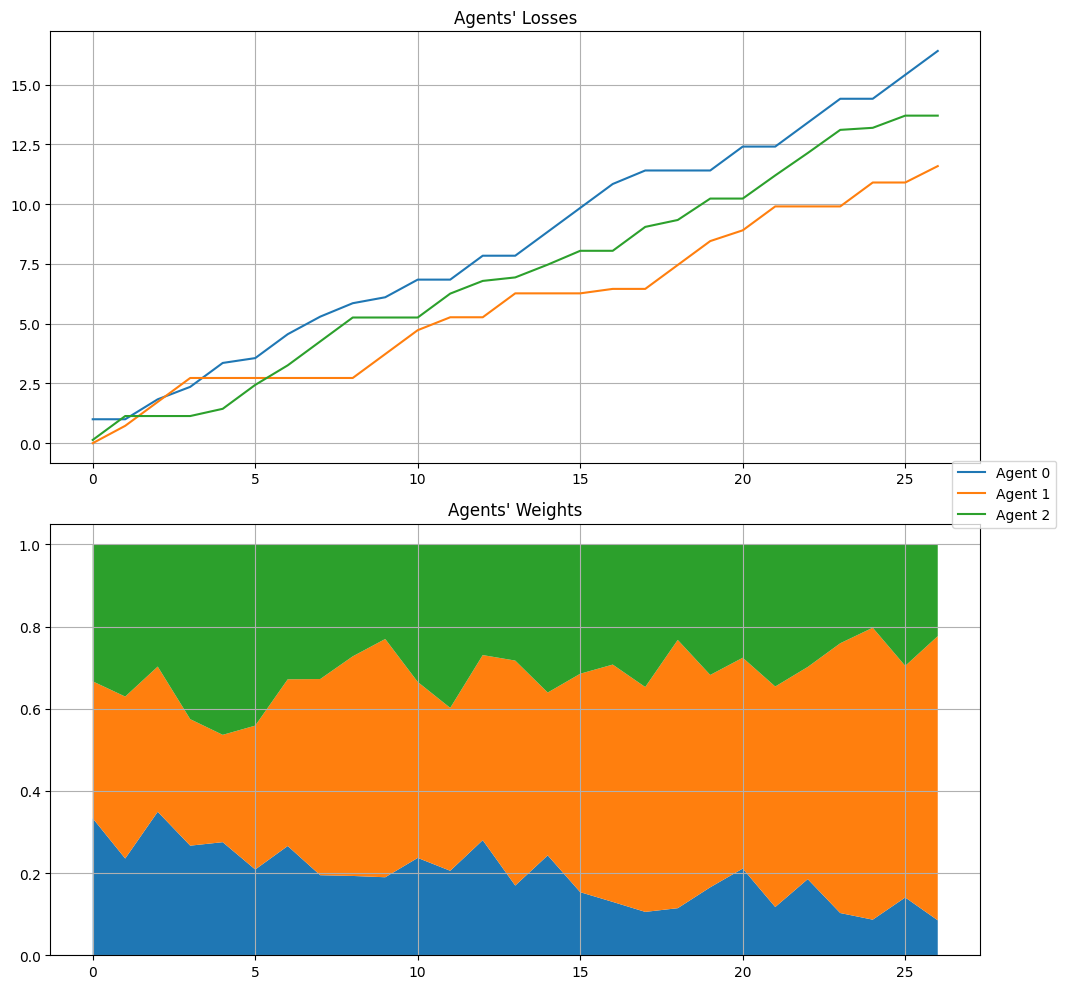

In [27]:
oamp.plot_stats()